In [1]:
import six
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.ops import math_ops
from deeplab import common
from deeplab import model
from deeplab.datasets import data_generator
from deeplab.utils import train_utils
import os
from deeplab.utils import get_dataset_colormap
from seg_exp import seg_encoder, seg_decoder
from bls2017_comp_seg import build_model
import numpy as np


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Model Definition

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '4'
#checkpoint_dir='/datatmp/Experiments/belbarashy/exps/seg_com_rgb_d/lambda_10.0/'
#checkpoint_dir='/datatmp/Experiments/belbarashy/exps/seg_com_rgb_d/lambda_1.0/'
checkpoint_dir='/datatmp/Experiments/belbarashy/exps/seg_comp_rgb_d_downby2/lambda_1.0/'

tf.logging.set_verbosity(tf.logging.INFO)
dataset = data_generator.Dataset(
      dataset_name='cityscapes',
      split_name='val',
      dataset_dir='/datatmp/Experiments/belbarashy/datasets/Cityscapes/tfrecord/',
      batch_size=1,
      crop_size=[int(sz) for sz in [1024,2048]],
      min_resize_value=None,
      max_resize_value=None,
      resize_factor=None,
      model_variant=None,
      num_readers=2,
      is_training=False,
      should_shuffle=False,
      should_repeat=False)

samples = dataset.get_one_shot_iterator().get_next()
in_imgs = samples['image']/255
depth   = samples['depth']/255
labels  = samples['label']  # channel=1
num_classes = dataset.num_of_classes
_, eval_bpp, _, x_hat, y_hat, y, string, _, seg_logits, seg_loss = \
build_model(in_imgs, depth, None, num_classes, mode='testing')

#label_downsampeld = tf.cast(L_c, tf.uint8)
label_downsampeld = tf.image.resize_bilinear(labels, tf.shape(y)[1:3], align_corners=True)
#label_downsampeld = label_downsampeld > 0 

if seg_logits is not None:
    predictions = tf.argmax(seg_logits, 3) # batch*H*W*1
else:
    predictions = x_hat

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.dropout instead.


# Network Disection

In [3]:
k = 210; c = 8;
A_210  = []
L_8  = []
dis_labels = []
dis_lats   = []
with tf.Session() as sess:
    latest = tf.train.latest_checkpoint(checkpoint_dir=checkpoint_dir)
    print(latest)
    tf.train.Saver().restore(sess, save_path=latest)    
    for i in range(500): #17
        p,l, lats, l_downsampeld, input_img, dep = sess.run([predictions, labels, y, label_downsampeld, in_imgs, depth])
        # ----------------------
        #l_8 = (l_downsampeld==c)
        #l_8 = l_8[0,:,:,0]
        #a_210 = lats[0,:,:,210]
        # ----------------------
        #A_210.append(a_210)
        #L_8.append(l_8)
        dis_labels.append(l_downsampeld)
        dis_lats.append(lats)

num_lat_units = dis_lats[0].shape[3]
#num_test_images = dis_labels.shape[0]
dis_labels = np.array(dis_labels)
dis_labels = np.squeeze(dis_labels)
units_responses = np.array(dis_lats)
units_responses = np.transpose(units_responses, (4, 0, 1, 2, 3))
units_responses = np.squeeze(units_responses)

print(units_responses.shape)
print(dis_labels.shape)

#A_210 = np.array(A_210)
#L_8 = np.array(L_8)

/datatmp/Experiments/belbarashy/exps/seg_comp_rgb_d_downby2/lambda_1.0/model.ckpt-200000
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /datatmp/Experiments/belbarashy/exps/seg_comp_rgb_d_downby2/lambda_1.0/model.ckpt-200000
(512, 500, 32, 64)
(500, 32, 64)


In [4]:
"""
import time
import datetime
print(datetime.datetime.now())

print(A_210.shape)
print(L_8.shape)
plt.figure(figsize=(18, 18))
plt.subplot(221)
plt.imshow( L_8[1,:,:] )
plt.subplot(222)
plt.imshow( input_img[0,:,:] )

plt.axis('off')
print(datetime.datetime.now())
"""

"\nimport time\nimport datetime\nprint(datetime.datetime.now())\n\nprint(A_210.shape)\nprint(L_8.shape)\nplt.figure(figsize=(18, 18))\nplt.subplot(221)\nplt.imshow( L_8[1,:,:] )\nplt.subplot(222)\nplt.imshow( input_img[0,:,:] )\n\nplt.axis('off')\nprint(datetime.datetime.now())\n"

In [5]:
import time 
import datetime


def score_IOU_kc(A_k, L, num_labels = 19):
    A_k_scores = []
    for label_idx in range(num_labels):
        L_c = (L==label_idx)
        # ============================ scale A_K ==> S_k
        #scaled above 
        # ============================ find threshold T_K
        taw = 0.005
        T_K = np.quantile(A_k, 1-taw) # == p(A>t) = taw
        # ============================ Thresholding S_K with T_k ==> M_k
        M_k = A_k > T_K
        # ============================ calculate IOU_kc
        IOU_kc = np.sum(np.logical_and(M_k, L_c)==True) / np.sum(np.logical_or(M_k, L_c)==True)
        A_k_scores.append(IOU_kc)
        #is_detector = IOU_kc > 0.04
        
    return A_k_scores
    

In [6]:
unit_scores = []
for unit_idx in range(units_responses.shape[0]):
    scores = score_IOU_kc(A_k = units_responses[unit_idx,:,:,:], L = dis_labels)
    unit_scores.append(scores)

In [7]:
number_of_units = len(unit_scores)
number_detectors = 0
number_uniqe_detectors = 0
detector_per_class = np.array([0]*19)
unique_detector_per_class = np.array([0]*19)
IOU_th = 0.01

for u_scores in unit_scores:
    is_detector_per_class   = np.array(np.array(u_scores) > IOU_th,  dtype=int)
    is_detector             = (sum(is_detector_per_class) > 0)
    is_unique_detector      = (sum(is_detector_per_class) == 1)
    number_detectors       += is_detector
    number_uniqe_detectors += is_unique_detector
    detector_per_class     += is_detector_per_class
    if is_unique_detector: 
        unique_detector_per_class += is_detector_per_class
    #print(is_detector_per_class, sum(is_detector_per_class))
print('number_of_units: ', number_of_units)
print('number_detectors: ', number_detectors)
print('number_uniqe_detectors: ', number_uniqe_detectors)
print(detector_per_class)
print(unique_detector_per_class)
sum(unique_detector_per_class)

number_of_units:  512
number_detectors:  66
number_uniqe_detectors:  37
[ 1 10  1  7  4  9 13 11  2  7  7 10 10  8  2  7 25  2 10]
[ 1  2  0  0  0  2  4  1  1  0  4  0  0  0  0  0 20  0  2]


37

In [8]:
cityscapes_id_class_color = [['road', 0, (128, 64,128)],
['sidewalk', 1, (244, 35,232)],
['building', 2, ( 70, 70, 70)],
['wall', 3, (102,102,156)],
['fence', 4, (190,153,153)],
['pole', 5, (153,153,153)],
['traffic light', 6, (250,170, 30)],
['traffic sign', 7, (220,220,  0)],
['vegetation', 8, (107,142, 35) ],
['terrain', 9, (152,251,152)],
['sky', 10, ( 70,130,180)],
['person', 11, (220, 20, 60)],
['rider', 12, (255,  0,  0) ],
['car', 13, (  0,  0,142)],
['truck', 14, ( 0,  0, 70)],
['bus', 15, (  0, 60,100)],
['train', 16, (  0, 80,100)],
['motorcycle', 17, (  0,  0,230)],
['bicycle', 18, (119, 11, 32)] ]

In [9]:
def convert_rgb(c):
    return (c[0]/255, c[1]/255, c[2]/255, 1)

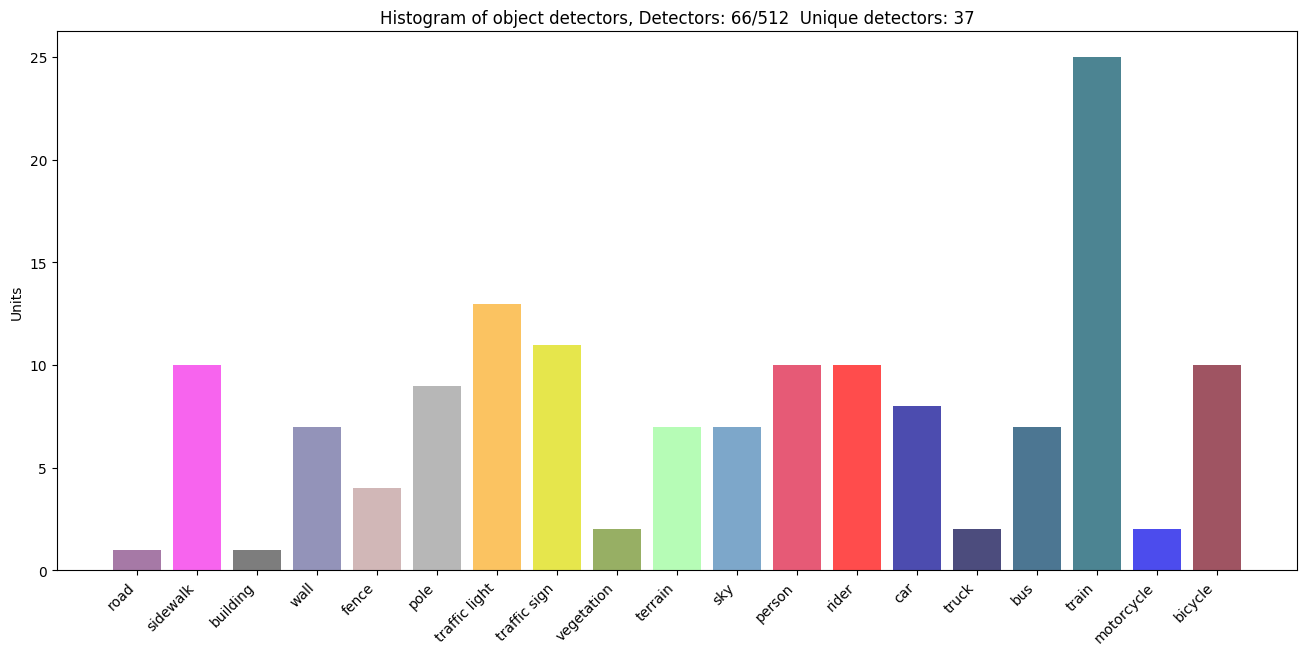

In [10]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

IOU_th_str = str(IOU_th)
IOU_th_str = IOU_th_str.replace('.','dot')

plt.figure(figsize=( 16,7))
objects = [x[0] for x in cityscapes_id_class_color]
colors  = [convert_rgb(x[2]) for x in cityscapes_id_class_color]
y_pos = np.arange(len(objects))
performance = detector_per_class
plt.bar(y_pos, performance, align='center', color=colors ,  alpha=0.7)
plt.xticks(y_pos, objects)
plt.ylabel('Units')
#ax.set_xticklabels( objects, rotation=45 )
plt.xticks(rotation=45, ha="right")
plt.title('Histogram of object detectors, Detectors: '+str(number_detectors) +'/'+str(number_of_units)+ '  Unique detectors: '+str(number_uniqe_detectors))

plt.savefig(checkpoint_dir+'Dissection_report_hist_IOU_th_'+IOU_th_str, bbox_inches='tight')

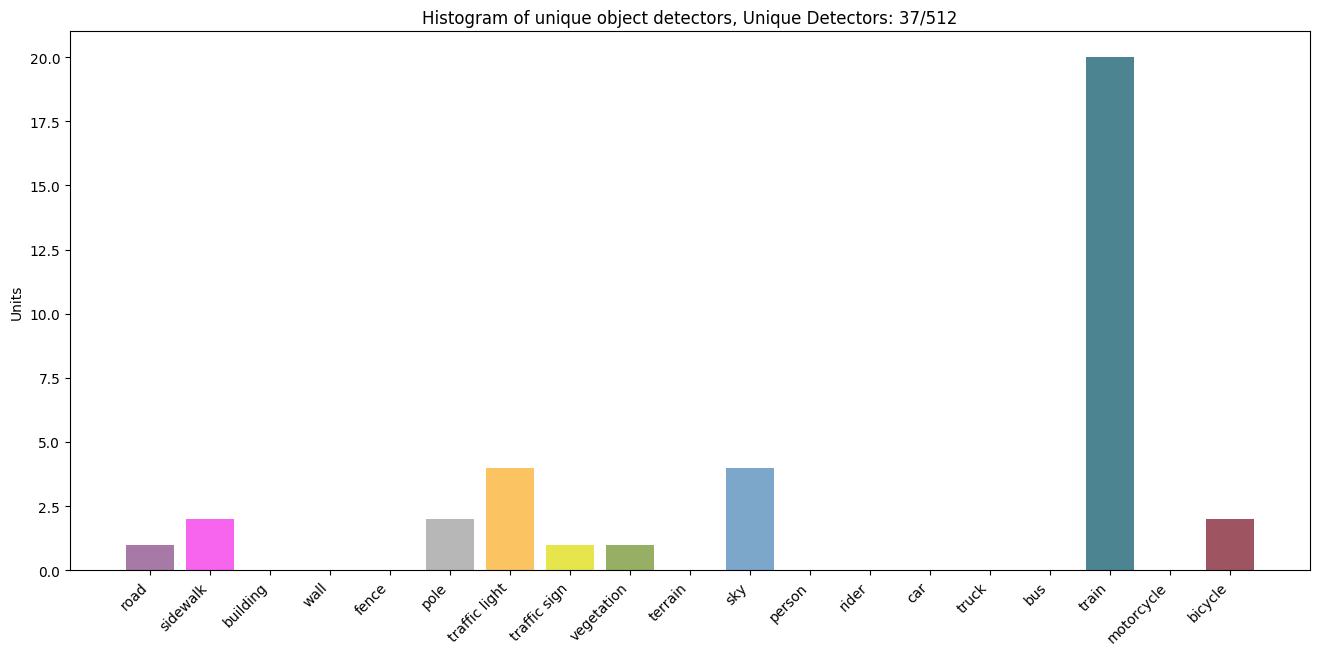

In [11]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

IOU_th_str = str(IOU_th)
IOU_th_str = IOU_th_str.replace('.','dot')

plt.figure(figsize=( 16,7))
objects = [x[0] for x in cityscapes_id_class_color]
colors  = [convert_rgb(x[2]) for x in cityscapes_id_class_color]
y_pos = np.arange(len(objects))
performance = unique_detector_per_class
plt.bar(y_pos, performance, align='center', color=colors ,  alpha=0.7)
plt.xticks(y_pos, objects)
plt.ylabel('Units')
#ax.set_xticklabels( objects, rotation=45 )
plt.xticks(rotation=45, ha="right")
plt.title('Histogram of unique object detectors, Unique Detectors: '+str(number_uniqe_detectors) +'/'+str(number_of_units))

plt.savefig(checkpoint_dir+'Dissection_report_unique_hist_IOU_th_'+IOU_th_str, bbox_inches='tight')

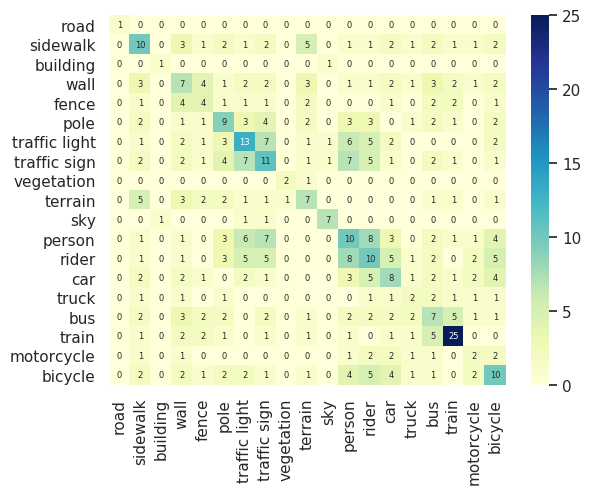

In [12]:
#plt.figure(figsize=( 8,6))
num_labels = 19
unit_confusion = np.zeros((num_labels,num_labels), dtype=int)#[[0]*num_labels]*num_labels
unit_class_mat = np.array(np.array(unit_scores) > IOU_th,  dtype=int)
for i in range(num_labels):
    for j in range(num_labels):
        for k in range(num_lat_units):
            unit_confusion[i][j] += ((unit_class_mat[k][i]) and (unit_class_mat[k][j]))

df_cm = pd.DataFrame(unit_confusion, range(num_labels), range(num_labels))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1)#for label size

sn.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 6}, 
           cmap="YlGnBu",
           xticklabels=objects[:num_labels],
           yticklabels=objects[:num_labels],
           fmt='g')# font size

plt.savefig(checkpoint_dir+'Dissection_report_confusion_IOU_th_'+IOU_th_str, bbox_inches='tight')

In [1]:
cityscapes_id_class_color = [['road', 0, (128, 64,128)],
['sidewalk', 1, (244, 35,232)],
['building', 2, ( 70, 70, 70)],
['wall', 3, (102,102,156)],
['fence', 4, (190,153,153)],
['pole', 5, (153,153,153)],
['traffic light', 6, (250,170, 30)],
['traffic sign', 7, (220,220,  0)],
['vegetation', 8, (107,142, 35) ],
['terrain', 9, (152,251,152)],
['sky', 10, ( 70,130,180)],
['person', 11, (220, 20, 60)],
['rider', 12, (255,  0,  0) ],
['car', 13, (  0,  0,142)],
['truck', 14, ( 0,  0, 70)],
['bus', 15, (  0, 60,100)],
['train', 16, (  0, 80,100)],
['motorcycle', 17, (  0,  0,230)],
['bicycle', 18, (119, 11, 32)] ]

In [2]:
[i[0] for i in cityscapes_id_class_color]

['road',
 'sidewalk',
 'building',
 'wall',
 'fence',
 'pole',
 'traffic light',
 'traffic sign',
 'vegetation',
 'terrain',
 'sky',
 'person',
 'rider',
 'car',
 'truck',
 'bus',
 'train',
 'motorcycle',
 'bicycle']